In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as ttf

import os
import os.path as osp

from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
VID_PATH = "/content/drive/MyDrive/Data/Dataset/Walking_with_compass/"
LABEL_PATH = "/content/drive/MyDrive/Data/official_labels/final_labels/walking/OF/"
PROCESSED_PATH = "/content/processed"
FRAME_RATE = 5

In [ ]:
os.mkdir(PROCESSED_PATH)

In [ ]:
"""
  Preprocess video data.
"""
import subprocess
import cv2

def map_to_multiclass(lab):
    if lab == 'LEFT':
        return 0
    if lab == 'RIGHT':
        return 1
    return 2

def get_all_files_from_dir(directory):
  file_paths = []
  for root, dirs, files in os.walk(directory):
      file_paths += [os.path.join(root, x) for x in files]
  return sorted(file_paths)

def get_lab(labels, time):
    for row in labels:
        if time <= float(row[2]) and time >= float(row[1]):
            return row[0]

def get_length(filename):
    result = subprocess.run(["ffprobe", "-v", "error", "-show_entries",
                             "format=duration", "-of",
                             "default=noprint_wrappers=1:nokey=1", filename],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT)
    return float(result.stdout)

def process_video(video_filename, label_filename):
    file_num = video_filename.split('/')[-1].split('.')[0].split("_")[-1]

    with open(label_filename, 'r') as f:
        labels_str = f.read()

    labels = [row.split('\t') for row in labels_str.split('\n')]

    vidcap = cv2.VideoCapture(video_filename)
    fps = vidcap.get(cv2.CAP_PROP_FPS)

    ctr = 0
    for row in labels:
      # vidcap.set(cv2.CAP_PROP_POS_MSEC, sec * 1000)
      hasFrames,image = vidcap.read()
      # print(hasFrames)
      if hasFrames:
        image_to_save = image[:,:,::-1]
        label_to_save = row[0]
        savefile = {'image': image_to_save, 'label': label_to_save}
        save_file_name = osp.join(PROCESSED_PATH, video_filename.split('/')[-1].split('.')[0] + "_" + str(ctr) + ".npy")
        np.save(save_file_name, savefile)
        ctr += 1

def preprocess():
  for video_filename, label_filename in tqdm(zip(get_all_files_from_dir(VID_PATH), get_all_files_from_dir(LABEL_PATH))):
    try:
      process_video(video_filename, label_filename)
      print("Finished processing ", video_filename)
    except Exception as e:
      print(video_filename)

In [ ]:
### preprocess videos
preprocess()

1it [00:06,  6.25s/it]

Finished processing  /content/drive/MyDrive/Data/Dataset/Walking_with_compass/walking_data_1.mp4


2it [00:13,  6.72s/it]

Finished processing  /content/drive/MyDrive/Data/Dataset/Walking_with_compass/walking_data_2.mp4


3it [00:21,  7.46s/it]

Finished processing  /content/drive/MyDrive/Data/Dataset/Walking_with_compass/walking_data_3.mp4


4it [00:27,  6.92s/it]

Finished processing  /content/drive/MyDrive/Data/Dataset/Walking_with_compass/walking_data_4.mp4


5it [00:35,  7.10s/it]

Finished processing  /content/drive/MyDrive/Data/Dataset/Walking_with_compass/walking_data_5.mp4


6it [00:41,  6.77s/it]

Finished processing  /content/drive/MyDrive/Data/Dataset/Walking_with_compass/walking_data_6.mp4


7it [01:07,  9.65s/it]

Finished processing  /content/drive/MyDrive/Data/Dataset/Walking_with_compass/walking_data_7.mp4


In [ ]:
! ls /content/processed

rm: cannot remove '/content/*.npy': No such file or directory


In [ ]:
BATCH = 4
SEQUENCE_LENGTH = 3
HEIGHT = 512
WIDTH = 512
CHANNELS = 3

In [ ]:
class VideoDataset(Dataset):
    def __init__(self, video_files, label_files, transforms):
        self.transforms = transforms
        self.filenames = video_files
        self.data = []

        for filename in self.filenames:
            filename_combined = filename.split('/')[-1].split('.')[0] + "_0.npy"
            i = 0
            while filename_combined in [f.split('/')[-1] for f in get_all_files_from_dir(PROCESSED_PATH)]:
                i += 1
                # frame = np.load(osp.join(PROCESSED_PATH, filename_combined), allow_pickle=True).item()
                self.data.append(filename_combined)
                filename_combined = filename.split('/')[-1].split('.')[0] + "_" + str(i) + ".npy"

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        filename_combined = self.data[idx]
        frame = np.load(osp.join(PROCESSED_PATH, filename_combined), allow_pickle=True).item()
        return self.transforms(frame['image'] / 255), map_to_multiclass(frame['label'])

In [ ]:
"""
We can also explore https://github.com/okankop/vidaug for video based augmentations.
"""

In [ ]:
data_files = np.array(get_all_files_from_dir(VID_PATH))
label_files = np.array(get_all_files_from_dir(LABEL_PATH))

# train_transforms = [ttf.ToTensor(), transforms.Resize((HEIGHT, WIDTH)), transforms.ColorJitter(), transforms.RandomRotation(10), transforms.GaussianBlur(3)]
train_transforms = [ttf.ToTensor(), transforms.Resize((HEIGHT, WIDTH))]
val_transforms = [ttf.ToTensor(), transforms.Resize((HEIGHT, WIDTH))]

X_train, X_test, y_train, y_test = train_test_split(data_files, label_files, test_size=0.2)

train_dataset = VideoDataset(X_train, y_train, transforms=ttf.Compose(train_transforms))
val_dataset = VideoDataset(X_test, y_test, transforms=ttf.Compose(val_transforms))

train_loader = DataLoader(train_dataset, batch_size=BATCH,
                          shuffle=False, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False, num_workers=2)

In [ ]:
print(len(train_dataset))

1009


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1, 1, 0, 0])


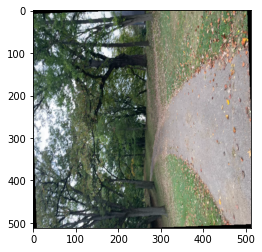

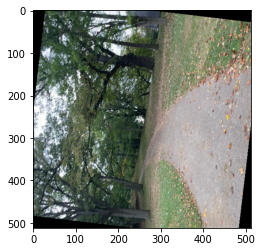

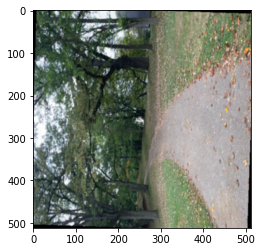

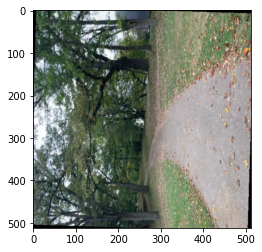

In [ ]:
for i, (x, y) in enumerate(train_loader):
  if i == 34:
    for img in x:
      img = img.permute(1,2,0)
      plt.figure()
      plt.imshow(img)
    break
  

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
dropout = 0.1
hidden = 1024
num_classes = 3
epochs = 20
lr = 0.001

In [ ]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y


class ConvNN_model(nn.Module):
    def __init__(self):
        super(ConvNN_model, self).__init__()
        self.layers = nn.Sequential(
                         nn.Conv2d(3, 16, kernel_size=3),
                         nn.MaxPool2d((3, 3)),
                         nn.Conv2d(16, 16, kernel_size=3),
                         nn.MaxPool2d((3, 3)),
                         nn.Conv2d(16, 16, kernel_size=3),
                         nn.MaxPool2d((3, 3)),
                         nn.Conv2d(16, 16, kernel_size=3),
                         nn.MaxPool2d((3, 3)),
                         nn.Flatten(),
                         nn.Linear(400, 20),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(20, 20),
                         nn.ReLU(),
                         nn.Linear(20, 20),
                         nn.ReLU(),
                         nn.Dropout(0.3),
                         nn.Linear(20, 20),
                         nn.ReLU(),
                         nn.Linear(20, 3),
                         nn.Softmax(dim=0))
    def forward(self, x):
        return self.layers(x)


In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, in_feats=1000, num_layers=1, num_classes=3, 
                 hidden=1024, dropout=0.):
        super().__init__()

        self.lstm_layer = nn.LSTM(in_feats, hidden, num_layers=num_layers, dropout=dropout)
        self.linear = nn.Linear(hidden, num_classes)

    def forward(self, x):
        with torch.no_grad():
            x = resnet18(x)
            x = torch.nn.functional.softmax(x, dim=0)
            x = torch.unsqueeze(x, 1)
        x, _ = self.lstm_layer(x)
        x = torch.squeeze(x, 1)
        x = self.linear(x)
        return nn.functional.softmax(x, dim=0)

In [ ]:
model = ConvNN_model()
model.to(device)

ConvNN_model(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=400, out_features=20, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): ReLU()
    (14): Linear(in_features=20, out_features=20, bias=True)
    (15): ReLU()
    (16): Dropout(p=0.3, inplace=Fa

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(len(train_loader) * epochs))

In [ ]:
for epoch in range(epochs):
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 

    num_correct = 0
    total_loss = 0

    for i, (x, y) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()

        x = x.float().to(device)
        y = y.to(device)
        
        with torch.cuda.amp.autocast():
            outputs = model(x)
            loss = criterion(outputs, y)

        num_correct += int((torch.argmax(outputs, axis=1) == y).sum())
        total_loss += float(loss)

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / ((i + 1) * BATCH)),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct,
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        
        scaler.scale(loss).backward()
        scaler.step(optimizer) 
        scaler.update()

        scheduler.step()

        batch_bar.update() # Update tqdm bar
    batch_bar.close()

    print("Epoch {}/{}: Train Acc {:.04f}%, Train Loss {:.04f}, Learning Rate {:.04f}".format(
        epoch + 1,
        epochs,
        100 * num_correct / (len(train_loader) * BATCH),
        float(total_loss / len(train_loader)),
        float(optimizer.param_groups[0]['lr'])))
    torch.save(model.state_dict(), PATH)
    
    # validation
    model.eval()
    val_num_correct = 0
    for i, (vx, vy) in enumerate(val_loader):

      vx = vx.float().cuda()
      vy = vy.cuda()

      with torch.no_grad():
          outputs = model(vx)
      val_num_correct += int((torch.argmax(outputs, axis=1) == vy).sum())
    print("Validation: {:.04f}%".format(100 * val_num_correct / len(val_dataset)))

    
batch_bar.close()

Epoch 1/20: Train Acc 31.2749%, Train Loss 1.0987, Learning Rate 0.0994


Validation: 37.1528%


Epoch 2/20: Train Acc 33.3665%, Train Loss 1.0987, Learning Rate 0.0976


Validation: 37.8472%


Epoch 3/20: Train Acc 36.1554%, Train Loss 1.0987, Learning Rate 0.0946


Validation: 38.8889%


Epoch 4/20: Train Acc 36.6534%, Train Loss 1.0986, Learning Rate 0.0905


Validation: 38.1944%


Epoch 5/20: Train Acc 41.0359%, Train Loss 1.0986, Learning Rate 0.0854


Validation: 40.2778%


Epoch 6/20: Train Acc 36.1554%, Train Loss 1.0987, Learning Rate 0.0794


Validation: 37.1528%


Epoch 7/20: Train Acc 37.1514%, Train Loss 1.0986, Learning Rate 0.0727


Validation: 35.0694%


Epoch 8/20: Train Acc 40.3386%, Train Loss 1.0987, Learning Rate 0.0655


Validation: 41.3194%


Epoch 9/20: Train Acc 35.5578%, Train Loss 1.0987, Learning Rate 0.0578


Validation: 30.2083%


Epoch 10/20: Train Acc 30.8765%, Train Loss 1.0987, Learning Rate 0.0500


Validation: 33.6806%


Epoch 11/20: Train Acc 30.4781%, Train Loss 1.0986, Learning Rate 0.0422


Validation: 35.0694%


Epoch 12/20: Train Acc 28.1873%, Train Loss 1.0986, Learning Rate 0.0345


Validation: 36.8056%


Epoch 13/20: Train Acc 29.1833%, Train Loss 1.0986, Learning Rate 0.0273


Validation: 34.7222%


Epoch 14/20: Train Acc 31.1753%, Train Loss 1.0986, Learning Rate 0.0206


Validation: 37.1528%


Epoch 15/20: Train Acc 29.6813%, Train Loss 1.0986, Learning Rate 0.0146


Validation: 35.0694%


Epoch 16/20: Train Acc 32.7689%, Train Loss 1.0986, Learning Rate 0.0095


Validation: 36.8056%


Epoch 17/20: Train Acc 31.7729%, Train Loss 1.0986, Learning Rate 0.0054


Validation: 37.8472%


Epoch 18/20: Train Acc 30.1793%, Train Loss 1.0986, Learning Rate 0.0024


Validation: 35.7639%


Epoch 19/20: Train Acc 32.2709%, Train Loss 1.0986, Learning Rate 0.0006


Validation: 36.8056%


Epoch 20/20: Train Acc 28.0876%, Train Loss 1.0987, Learning Rate 0.0000


Validation: 37.1528%
